In [1]:
import pandas as pd
import numpy as np

import matplotlib as m_plt
from matplotlib import pyplot as plt
import matplotlib.mlab as mlabQ

import seaborn as sns

from copy import copy
from pprint import pprint

import sys
import os

import personal_plotter as p_plt

In [2]:
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from numpy import mean, std


def reg_clas(data, columns, target, regression=False):
    """
    Executa classificação ou regressão do conjunto de dados passado
    ---------------------------------------------------------------
    data:       DataFrame. Conjunto de dados
    columns:    Lista de inteiros. Índice das colunas utilizadas no treinamento e teste
    target:     Inteiro. Índice da coluna alvo
    regression: Boleano. True para realizar uma regressão e False para classificação
    ---------------------------------------------------------------
    Realiza a classificação/regressão em 4 modelos (SVM com kernel linear, 
    SVM com kernel polinomial de grau 3, Árvore de decisão, e knn com k=5)
    Plot o gráfico de desempenho para cada classificador/regressor.
    Retorna um dicionário com os classificadores/regressores treinados e as medidas de desempenho
    """
    
    # inicializa os modelos com os parâmetros solicitados
    if regression:
        svm_l = SVR(C=10*len(data), kernel='linear', cache_size=500, max_iter=1e6)
        svm_n = SVR(C=10*len(data), kernel='poly', degree=3, gamma=1, coef0=1, cache_size=500, max_iter=1e6)
        dt = DecisionTreeRegressor(criterion='mse', splitter='best', min_samples_split=int(len(data)*0.05))
        knn = KNeighborsRegressor(n_neighbors=5, weights='uniform', algorithm='kd_tree')
    else:
        svm_l = SVC(C=10*len(data), kernel='linear', cache_size=500, max_iter=1e6)
        svm_n = SVC(C=10*len(data), kernel='poly', degree=3, gamma=1, coef0=1, cache_size=500, max_iter=1e6)
        dt = DecisionTreeClassifier(criterion='gini', splitter='best', min_samples_split=int(len(data)*0.1))
        knn = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='kd_tree')
    
    clfs = [svm_l, svm_n, dt, knn]
    clfs_names = ['svm_linear', 'svm_poly', 'dt', 'knn']
    
    # prepara validação cruzada
    # faz divisão do dataset em 5 partes
    cv = KFold(n_splits=5, shuffle=True)
    
    # itera para cada classificador fazendo treino e teste
    results = {'svm_linear':[], 'svm_poly':[], 'dt':[], 'knn':[]}
    for c, c_name in zip(clfs, clfs_names):
        for train_index, test_index in cv.split(data):
            
            # separa conjunto de treino e de teste
            x_train, y_train = data.iloc[train_index, columns], data.iloc[train_index, target]
            x_test, y_test = data.iloc[test_index, columns], data.iloc[test_index, target]
            
            # faz o treino do modelo
            clf = c.fit(X=x_train, y=y_train)
            
            # realiza predição no conjunto de teste e salva o resultado
            if regression:
                results[c_name].append( mean_squared_error(clf.predict(x_test), y_test) )
            else:
                results[c_name].append( clf.score(x_test, y_test) )
    
    # faz o plot de desempenho dos classificadores/regressores
    plt.figure(figsize=(8,8))
    plt.bar(range(1, len(clfs)+1), [mean(results[name]) for name in clfs_names], 
                                yerr=[std(results[name]) for name in clfs_names])
    plt.xticks(range(1, len(clfs)+1), clfs_names, rotation=45)
    title = 'Desempenho dos regressores - erro quadrático médio' if regression else \
            'Desempenho dos classificadores - acurácia'
    plt.title(title)
    plt.show()
    
    return {'results': results, 'clfs':clfs}

# Agro Data

## 1. Data

***This case it's a temporal, thus , doesnt have hypotesis*** 

In [3]:
#/agro/data_dict.xlsx
try :
    agro_dataset = pd.read_csv("./agro/falhas_plantio_hashing.csv", sep=';', encoding='latin3')
except:
    print("ERROR, DATA NOT LOADED")
else:
    print("""DATA SUCCESSFULLY LOADED\n
    \tRows\t:\t{:d}\t|\tColumns\t:\t{:d}""".format(agro_dataset.shape[0], agro_dataset.shape[1]))

DATA SUCCESSFULLY LOADED

    	Rows	:	6302	|	Columns	:	212


### 1.1 - Data Labels

In [4]:
agro_dataset_descriptions = pd.read_excel("./agro/data_dict.xlsx")

agro_dataset_descriptions

,Campos,Descrição
0,CD_SAFRA,Safra na qual se realizou o plantio
1,Area_Plantio,Área de Plantio
2,Perc_Falha,Porcentagem de Falhas no plantio
3,Perc_Infest_Inv,Porcentagem de infestação de pragas
4,Ciclo,Ciclo de plantio
5,CD_TP_SOLO,Tipo de solo
6,CD_CLAS_DECL,Declividade
7,CD_CLAS_FERT,Tipo de Fertilizante
8,CD_TEXT_SOLO,Textura do solo
9,CD_TOPOG,Topologia


### 1.2.- Viewing Data

In [5]:
agro_dataset = agro_dataset.iloc[:, 1:]

In [6]:
agro_dataset.iloc[10:15, :]

,Fazenda,Zona,Talhao,Nome_Estacao_SM1,INSTANCIA1,CD_EMPRESA1,Tipo_prop1,CD_SAFRA,Area_Plantio,Perc_Falha,...,EPT_mm_December,EPT_mm_February,EPT_mm_January,EPT_mm_July,EPT_mm_June,EPT_mm_March,EPT_mm_May,EPT_mm_November,EPT_mm_October,EPT_mm_September
10,647052da17e3340e599d54abde4858a7,4d4c1ad2286f1a7670a024467dd10808,71db8a6cad03244e6e50f0ad8bc95a65,9d808d5988da444614e97bb46dfcc388,4770fa66c5954411ff928125d447259b,c7f66da1cae4f223b9bae717f05900f7,c7f66da1cae4f223b9bae717f05900f7,21617,0.64,0.0360,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,647052da17e3340e599d54abde4858a7,4d4c1ad2286f1a7670a024467dd10808,8f3571abef23f6aca0f7b8666a74e7e0,9d808d5988da444614e97bb46dfcc388,4770fa66c5954411ff928125d447259b,c7f66da1cae4f223b9bae717f05900f7,c7f66da1cae4f223b9bae717f05900f7,21617,0.80,0.0465,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,647052da17e3340e599d54abde4858a7,4d4c1ad2286f1a7670a024467dd10808,fa5a4df7ac0f9782037da890557fd8b8,9d808d5988da444614e97bb46dfcc388,4770fa66c5954411ff928125d447259b,c7f66da1cae4f223b9bae717f05900f7,c7f66da1cae4f223b9bae717f05900f7,21617,5.37,0.0689,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,647052da17e3340e599d54abde4858a7,4d4c1ad2286f1a7670a024467dd10808,8ae1ac7bdf62dca7c19b427a9153445c,9d808d5988da444614e97bb46dfcc388,4770fa66c5954411ff928125d447259b,c7f66da1cae4f223b9bae717f05900f7,c7f66da1cae4f223b9bae717f05900f7,21617,5.52,0.0589,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,647052da17e3340e599d54abde4858a7,4d4c1ad2286f1a7670a024467dd10808,06cd248dd1409b804444bd9ad5533d1d,9d808d5988da444614e97bb46dfcc388,4770fa66c5954411ff928125d447259b,c7f66da1cae4f223b9bae717f05900f7,c7f66da1cae4f223b9bae717f05900f7,21617,2.60,0.0843,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2.- NA & NULL Analysis

### 2.0 - Unique Rows

In [7]:
unique_agro_dataset = agro_dataset.drop_duplicates().copy()
unique_agro_dataset
print("Number of non-unique rows {:d}".format(unique_agro_dataset.shape[0] - agro_dataset.shape[0]))

Number of non-unique rows 0


This DataSet doesn't have any duplicate row

### 2.1 - Exploration


> 	 max amount of NA/NULL per column =	5151
> 	 ratio (Max/Rows) =	0.8174

> 	 ^ % Max NA/NULL =	81.7360
# 	 v Column =	CD_EST_POST_BIS

> 	 ^ % Min NA/NULL =	0.0000
# 	 v Column =	Fazenda

> 	 Mean NA/NULL =	1181.6919
> 	 ^ % Mean NA/NULL =	18.7511

> 	 Number of coloumns with NA/NULL =	200
> 	 Total of Columns =	211
> 	 ^ % Amount NA/NULL =	94.7867 



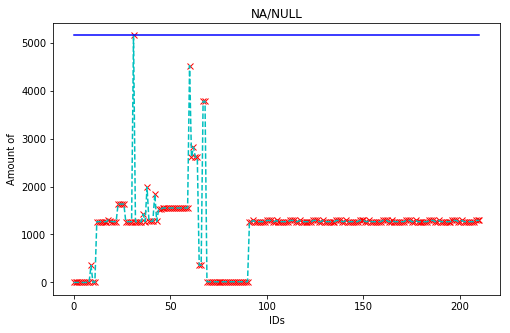


> 	 max amount of not NA/NULL per column =	6302
> 	 ratio (Max/Rows) =	1.0000

> 	 ^ % Max not NA/NULL =	100.0000
# 	 v Column =	Fazenda

> 	 ^ % Min not NA/NULL =	18.2640
# 	 v Column =	CD_EST_POST_BIS

> 	 Mean not NA/NULL =	5120.3081
> 	 ^ % Mean not NA/NULL =	81.2489

> 	 Number of coloumns without NA/NULL =	211
> 	 Total of Columns =	211
> 	 ^ % Amount of Not NA/NULL =	100.0000 



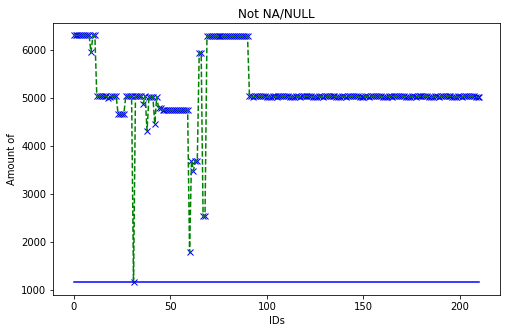

In [8]:
temp_ids = np.arange(agro_dataset.columns.size)
temp_max_amount = agro_dataset.shape[0]


##### NA/NULL

plt.figure(figsize=(8,5))
temp_vals = agro_dataset.isna().astype(int).sum()

plt.plot(temp_ids, temp_vals, "rx")
plt.plot(temp_ids, temp_vals, "c--")

plt.plot(temp_ids, temp_vals.max() * np.ones(temp_ids.size), "b-")

plt.title("NA/NULL")
plt.xlabel("IDs")
plt.ylabel("Amount of")

print(
"""
> \t max amount of NA/NULL per column =\t{:d}
> \t ratio (Max/Rows) =\t{:3.4f}

> \t ^ % Max NA/NULL =\t{:3.4f}
# \t v Column =\t{:s}

> \t ^ % Min NA/NULL =\t{:3.4f}
# \t v Column =\t{:s}

> \t Mean NA/NULL =\t{:3.4f}
> \t ^ % Mean NA/NULL =\t{:3.4f}

> \t Number of coloumns with NA/NULL =\t{:d}
> \t Total of Columns =\t{:d}
> \t ^ % Amount NA/NULL =\t{:3.4f} 
""".format( temp_vals.max(),
            temp_vals.max() / temp_max_amount,
            (temp_vals.max() / temp_max_amount) * 100, 
            temp_vals.idxmax(), 
            (temp_vals.min() / temp_max_amount) * 100, 
            temp_vals.idxmin(), 
            temp_vals.mean(), 
            (temp_vals.mean() / temp_max_amount) * 100,
            (temp_vals > 0).astype(int).sum(),
            temp_vals.size,
            ((temp_vals > 0).astype(int).sum() / temp_vals.size) * 100
          )
)

plt.show()
      
      
##### NOT NA/NULL

plt.figure(figsize=(8,5))
temp_vals = agro_dataset.notna().astype(int).sum()

plt.plot(temp_ids, temp_vals, 'bx')
plt.plot(temp_ids, temp_vals, 'g--')

plt.plot(temp_ids, temp_vals.min() * np.ones(temp_ids.size), "b-")

plt.title("Not NA/NULL")
plt.xlabel("IDs")
plt.ylabel("Amount of")

print(
"""
> \t max amount of not NA/NULL per column =\t{:d}
> \t ratio (Max/Rows) =\t{:3.4f}

> \t ^ % Max not NA/NULL =\t{:3.4f}
# \t v Column =\t{:s}

> \t ^ % Min not NA/NULL =\t{:3.4f}
# \t v Column =\t{:s}

> \t Mean not NA/NULL =\t{:3.4f}
> \t ^ % Mean not NA/NULL =\t{:3.4f}

> \t Number of coloumns without NA/NULL =\t{:d}
> \t Total of Columns =\t{:d}
> \t ^ % Amount of Not NA/NULL =\t{:3.4f} 
""".format( temp_vals.max(),
            temp_vals.max() / temp_max_amount,
            (temp_vals.max() / temp_max_amount) * 100, 
            temp_vals.idxmax(), 
            (temp_vals.min() / temp_max_amount) * 100, 
            temp_vals.idxmin(), 
            temp_vals.mean(), 
            (temp_vals.mean() / temp_max_amount) * 100,
            (temp_vals != 0).astype(int).sum(),
            temp_vals.size,
            ((temp_vals != 0).astype(int).sum() / temp_vals.size) * 100
          )
)


plt.show()

### 2.1- Observation (Part 1)

* Every column has data
* At least 1 column doesnt have NA/NULL values.
* The 94.8% of data rows has NA/NULL values.

In [9]:
agro_dataset.describe(include='all')

,Fazenda,Zona,Talhao,Nome_Estacao_SM1,INSTANCIA1,CD_EMPRESA1,Tipo_prop1,CD_SAFRA,Area_Plantio,Perc_Falha,...,EPT_mm_December,EPT_mm_February,EPT_mm_January,EPT_mm_July,EPT_mm_June,EPT_mm_March,EPT_mm_May,EPT_mm_November,EPT_mm_October,EPT_mm_September
count,6302,6302,6302,6302,6302,6302,6302,6302.000000,6302.000000,5948.000000,...,5010.000000,5035.000000,5035.000000,5035.000000,5035.000000,5035.000000,5035.000000,5010.000000,5010.000000,5010.000000
unique,561,362,105,13,20,20,6,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,b7003eda5916045f6d0d71829fc04846,4b5630ee914e848e8d07221556b0a2fb,4b5630ee914e848e8d07221556b0a2fb,9d808d5988da444614e97bb46dfcc388,4770fa66c5954411ff928125d447259b,c7f66da1cae4f223b9bae717f05900f7,c01f179e4b57ab8bd9de309e6d576c48,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,134,631,513,1267,1267,1267,4292,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21679.247540,9.783290,0.056297,...,135.668984,119.608214,125.427019,88.464804,66.143293,129.955104,74.811178,133.527788,137.175465,143.946898
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.118511,13.124769,0.089453,...,13.664263,12.724072,10.893325,15.738755,12.307184,9.117529,9.991296,13.464673,14.613832,20.122447
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21617.000000,0.020000,0.000000,...,109.300000,101.230000,106.730000,54.800000,49.000000,106.700000,59.400000,114.900000,110.600000,105.600000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21617.000000,3.120000,0.007875,...,125.900000,109.950000,116.000000,76.900000,58.500000,124.000000,65.800000,123.900000,127.300000,135.610000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21718.000000,6.420000,0.024200,...,134.600000,111.060000,123.400000,86.300000,59.900000,127.400000,70.860000,127.200000,135.300000,142.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21718.000000,12.462500,0.063300,...,148.300000,128.950000,133.530000,98.800000,73.900000,139.500000,85.400000,146.400000,142.900000,164.000000



> 	 max amount of NA/NULL per column =	5151
> 	 ratio (Max/Rows) =	0.8174

> 	 ^ Max NA/NULL =	5151.0000
> 	 ^ % Max NA/NULL =	81.7360
# 	 v Column =	CD_EST_POST_BIS

> 	 ^ Min NA/NULL =	14.0000
> 	 ^ % Min NA/NULL =	0.2222
# 	 v Column =	ADEF_KG

> 	 Mean NA/NULL =	1246.6850
> 	 ^ % Mean NA/NULL =	19.7824

> 	 Total of Columns =	200



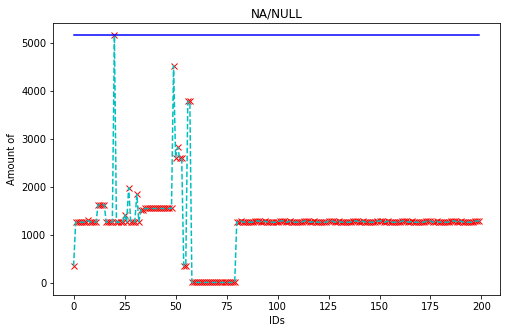

In [10]:
##### NA/NULL

plt.figure(figsize=(8,5))

temp_vals = agro_dataset.isna().astype(int).sum()
temp_vals = temp_vals[temp_vals != 0]

temp_ids = np.arange(temp_vals.size)
temp_max_amount = agro_dataset.shape[0]

plt.plot(temp_ids, temp_vals, "rx")
plt.plot(temp_ids, temp_vals, "c--")

plt.plot(temp_ids, temp_vals.max() * np.ones(temp_ids.size), "b-")

plt.title("NA/NULL")
plt.xlabel("IDs")
plt.ylabel("Amount of")

print(
"""
> \t max amount of NA/NULL per column =\t{:d}
> \t ratio (Max/Rows) =\t{:3.4f}

> \t ^ Max NA/NULL =\t{:3.4f}
> \t ^ % Max NA/NULL =\t{:3.4f}
# \t v Column =\t{:s}

> \t ^ Min NA/NULL =\t{:3.4f}
> \t ^ % Min NA/NULL =\t{:3.4f}
# \t v Column =\t{:s}

> \t Mean NA/NULL =\t{:3.4f}
> \t ^ % Mean NA/NULL =\t{:3.4f}

> \t Total of Columns =\t{:d}
""".format( temp_vals.max(),
            temp_vals.max() / temp_max_amount,
            temp_vals.max(),
            (temp_vals.max() / temp_max_amount) * 100, 
            temp_vals.idxmax(),
            temp_vals.min(), 
            (temp_vals.min() / temp_max_amount) * 100, 
            temp_vals.idxmin(), 
            temp_vals.mean(), 
            (temp_vals.mean() / temp_max_amount) * 100,
            temp_vals.size
          )
)

plt.show()

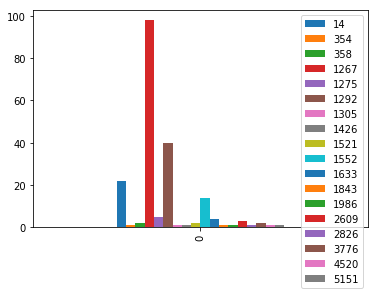

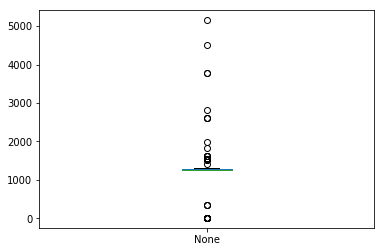

In [11]:
x = temp_vals.unique()
x.sort()

temp_df = pd.DataFrame()
for i in x:
    temp_df[i] = [temp_vals[temp_vals == i].size]

temp_df.plot.bar()
plt.show()

temp_vals.plot.box()
plt.show()



### 2.2 Quartiles Exploration

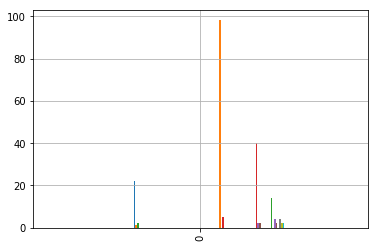

,11,12,13,62,64,84,85,86,93,95,96,98,99,100
0,22,1,2,98,5,40,2,2,14,4,2,4,2,2


In [12]:
# creating targets (n families , i-Quantile)
n = int(100)
temp_quartils = p_plt.make_targets(temp_vals, samples=n)

temp_df = pd.DataFrame()
for i in range(1,n + 1,1):
    temp_df[i] = [temp_quartils[temp_quartils == i].size]


temp_df.plot.bar(legend=False)
plt.grid()
plt.show()

temp_df[temp_df > 0].dropna(axis=1)

In [13]:
for jj in temp_df[temp_df > 0].dropna(axis=1):
    print(
    """
    {:d}-Quantile
    Min \t : {:d}
    Max \t : {:d}
    #er of Elements in between \t : {:d}
    """.format( jj,
                temp_vals[temp_quartils[temp_quartils == jj].index].min(),
                temp_vals[temp_quartils[temp_quartils == jj].index].max(),
                temp_vals[temp_quartils[temp_quartils == jj].index].size)
    )


    11-Quantile
    Min 	 : 14
    Max 	 : 14
    #er of Elements in between 	 : 22
    

    12-Quantile
    Min 	 : 354
    Max 	 : 354
    #er of Elements in between 	 : 1
    

    13-Quantile
    Min 	 : 358
    Max 	 : 358
    #er of Elements in between 	 : 2
    

    62-Quantile
    Min 	 : 1267
    Max 	 : 1267
    #er of Elements in between 	 : 98
    

    64-Quantile
    Min 	 : 1275
    Max 	 : 1275
    #er of Elements in between 	 : 5
    

    84-Quantile
    Min 	 : 1292
    Max 	 : 1292
    #er of Elements in between 	 : 40
    

    85-Quantile
    Min 	 : 1305
    Max 	 : 1426
    #er of Elements in between 	 : 2
    

    86-Quantile
    Min 	 : 1521
    Max 	 : 1521
    #er of Elements in between 	 : 2
    

    93-Quantile
    Min 	 : 1552
    Max 	 : 1552
    #er of Elements in between 	 : 14
    

    95-Quantile
    Min 	 : 1633
    Max 	 : 1633
    #er of Elements in between 	 : 4
    

    96-Quantile
    Min 	 : 1843
    Max 	 : 1986
    #er of Elements in 

### 2.3 - Observation (Part 2)

- Above 1650 the amount of NA/NULL is very low but significatly higher in its impact(number of columns)
- Below 1650 the amount of NA/NULL is very high but relative lower in its impact(number of columns)

### 2.4 - Way to Work

- Make a cut (at 1600)
- Below of : Data imputation
- Above of : Drop NA/NULL

## 3.- Pre-Processing

### 3.1.- NA/Null Cleaning

In [14]:
columns_to_imput = temp_vals[temp_vals < 1600].index
columns_to_drop = temp_vals[temp_vals >= 1600].index

In [15]:
#agro_dataset[columns_to_drop].isna().astype(int).sum().max()

agro_dataset_zero = agro_dataset.copy()
agro_dataset_mean = agro_dataset.copy()
agro_dataset_median = agro_dataset.copy()

agro_dataset_mixed = agro_dataset.copy()

In [16]:
temp = agro_dataset_mixed[columns_to_imput]

fill_pad_range = 46

temp = temp.fillna(method='pad', limit=fill_pad_range)
temp = temp.fillna(method='bfill', limit=fill_pad_range)

print("NA/NULL left :\t{:d}".format(temp.isna().astype(int).sum().max()))

NA/NULL left :	0


In [17]:
# subst. NA using mixed methods and data imputation by segments
agro_dataset_mixed[columns_to_imput] = temp
agro_dataset_mixed.drop(columns=columns_to_drop , axis=1, inplace=True)

print("NA/NULL left :\t{:d}".format(agro_dataset_mixed.isna().astype(int).sum().max()))

NA/NULL left :	0


In [18]:
# subst. NA for 0
agro_dataset_zero.fillna(value=0, axis=0, inplace=True)
print("NA/NULL left :\t{:d}".format(agro_dataset_zero.isna().astype(int).sum().max()))

# subst. NA for the mean
agro_dataset_mean.fillna(value=agro_dataset_mean.mean(), axis=0, inplace=True)
print("NA/NULL left :\t{:d}".format(agro_dataset_mean.isna().astype(int).sum().max()))

# subst. NA for the median
agro_dataset_median.fillna(value=agro_dataset_median.median(), axis=0, inplace=True)
print("NA/NULL left :\t{:d}".format(agro_dataset_median.isna().astype(int).sum().max()))

NA/NULL left :	0
NA/NULL left :	1843
NA/NULL left :	1843


In [19]:
# subst. NA for the mode
agro_dataset_mean.fillna(value=agro_dataset.mode(axis=0).iloc[0, :], axis=0, inplace=True)
print("NA/NULL left :\t{:d}".format(agro_dataset_mean.isna().astype(int).sum().max()))

# subst. NA for the mode
agro_dataset_median.fillna(value=agro_dataset.mode(axis=0).iloc[0, :], axis=0, inplace=True)
print("NA/NULL left :\t{:d}".format(agro_dataset_median.isna().astype(int).sum().max()))

NA/NULL left :	0
NA/NULL left :	0


### 3.2.- Numeric Values Filtering

In [20]:
agro_dataset_zero = agro_dataset_zero._get_numeric_data()
agro_dataset_mean = agro_dataset_mean._get_numeric_data()
agro_dataset_median = agro_dataset_median._get_numeric_data()
agro_dataset_mixed = agro_dataset_mixed._get_numeric_data()

## 4.- Processing
### 4.1- Creating the Target Values

In [21]:
# the function "Make Targets" generate a list of id's (labels) using the n - quantil function

target = agro_dataset["Perc_Infest_Inv"] * 100
target = target.round(4)
target = p_plt.make_targets(target, 3)
target.unique()

array([2, 3], dtype=int64)

In [22]:
target[target == 2] = 0
target[target == 3] = 1

agro_dataset["target"] = target
agro_dataset.target.unique()

array([0, 1], dtype=int64)

In [23]:
agro_dataset_zero["target"] = target
agro_dataset_mean["target"] = target
agro_dataset_median["target"] = target
agro_dataset_mixed["target"] = target

### 4.2.- Making Predictions

#### 4.2.1.- Zero Fill Data

C:\Users\10659682\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\10659682\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\10659682\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\10659682\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your d

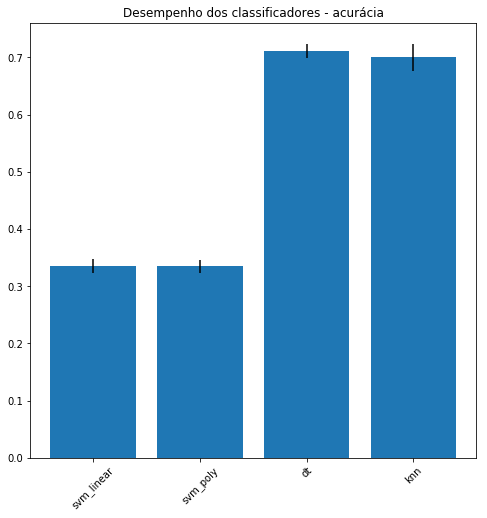

{'results': {'svm_linear': [0.31800158604282314,
   0.3473433782712133,
   0.3484126984126984,
   0.3349206349206349,
   0.3261904761904762],
  'svm_poly': [0.337827121332276,
   0.33068992862807295,
   0.32222222222222224,
   0.32857142857142857,
   0.35555555555555557],
  'dt': [0.7081681205392546,
   0.6923076923076923,
   0.7238095238095238,
   0.7071428571428572,
   0.7253968253968254],
  'knn': [0.6772402854877082,
   0.7129262490087233,
   0.6666666666666666,
   0.7126984126984127,
   0.7309523809523809]},
 'clfs': [SVC(C=63020, cache_size=500, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=1000000.0, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False),
  SVC(C=63020, cache_size=500, class_weight=None, coef0=1,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='poly',
    max_iter=1000000.0, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbos

In [24]:
data = agro_dataset_zero
target = data.shape[1] - 1
columns = [i in range(data.shape[1] - 1)]
reg_clas(data, columns, target, regression=False)

#### 4.2.2.- Mean Fill Data

C:\Users\10659682\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\10659682\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\10659682\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\10659682\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your d

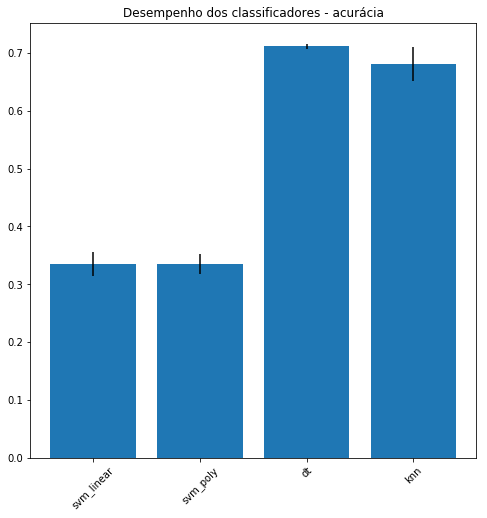

{'results': {'svm_linear': [0.31958762886597936,
   0.3402061855670103,
   0.3055555555555556,
   0.3476190476190476,
   0.3619047619047619],
  'svm_poly': [0.3465503568596352,
   0.317208564631245,
   0.3547619047619048,
   0.3126984126984127,
   0.34365079365079365],
  'dt': [0.7129262490087233,
   0.7105471847739889,
   0.7103174603174603,
   0.703968253968254,
   0.719047619047619],
  'knn': [0.6629659000793021,
   0.6605868358445678,
   0.6507936507936508,
   0.7,
   0.7293650793650793]},
 'clfs': [SVC(C=63020, cache_size=500, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=1000000.0, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False),
  SVC(C=63020, cache_size=500, class_weight=None, coef0=1,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='poly',
    max_iter=1000000.0, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False),
  Decision

In [25]:
data = agro_dataset_mean
target = data.shape[1] - 1
columns = [i in range(data.shape[1] - 1)]
reg_clas(data, columns, target, regression=False)

#### 4.2.3.- Median Fill Data

C:\Users\10659682\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\10659682\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\10659682\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\10659682\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your d

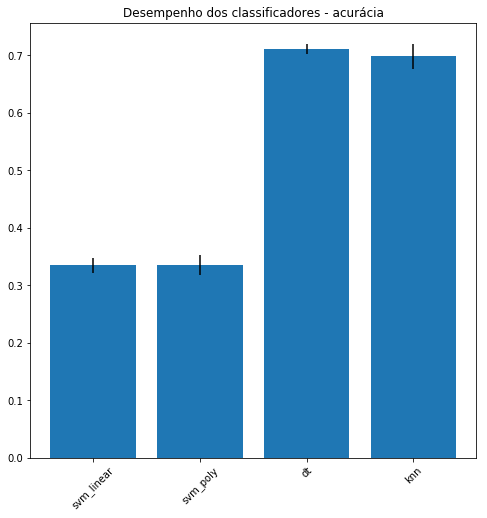

{'results': {'svm_linear': [0.3600317208564631,
   0.32355273592386996,
   0.3261904761904762,
   0.3349206349206349,
   0.33015873015873015],
  'svm_poly': [0.352101506740682,
   0.31800158604282314,
   0.3111111111111111,
   0.3476190476190476,
   0.346031746031746],
  'dt': [0.6986518636003172,
   0.7129262490087233,
   0.7222222222222222,
   0.7063492063492064,
   0.7166666666666667],
  'knn': [0.6582077716098335,
   0.6978588421887391,
   0.7,
   0.7150793650793651,
   0.7214285714285714]},
 'clfs': [SVC(C=63020, cache_size=500, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=1000000.0, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False),
  SVC(C=63020, cache_size=500, class_weight=None, coef0=1,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='poly',
    max_iter=1000000.0, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False),
  Decisi

In [26]:
data = agro_dataset_median
target = data.shape[1] - 1
columns = [i in range(data.shape[1] - 1)]
reg_clas(data, columns, target, regression=False)

#### 4.2.4.- Mixed Fill Data

C:\Users\10659682\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\10659682\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\10659682\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\10659682\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your d

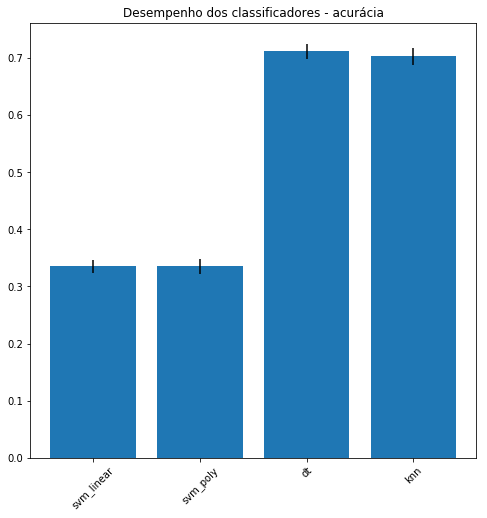

{'results': {'svm_linear': [0.3148295003965107,
   0.3457573354480571,
   0.3404761904761905,
   0.34444444444444444,
   0.32936507936507936],
  'svm_poly': [0.3457573354480571,
   0.34258524980174465,
   0.3103174603174603,
   0.3380952380952381,
   0.3380952380952381],
  'dt': [0.7129262490087233,
   0.6907216494845361,
   0.7142857142857143,
   0.7055555555555556,
   0.7333333333333333],
  'knn': [0.7192704203013481,
   0.7208564631245044,
   0.6825396825396826,
   0.6904761904761905,
   0.7]},
 'clfs': [SVC(C=63020, cache_size=500, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=1000000.0, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False),
  SVC(C=63020, cache_size=500, class_weight=None, coef0=1,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='poly',
    max_iter=1000000.0, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False),
  Deci

In [27]:
data = agro_dataset_mixed
target = data.shape[1] - 1
columns = [i in range(data.shape[1] - 1)]
reg_clas(data, columns, target, regression=False)